In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import os
import tempfile

import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages')
import keras
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
data = pd.read_csv('Data/creditcard.csv')

A quick view of the data

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64
Proportion of Non-Fraud: 0.99827
Proportion of Fraud: 0.00173


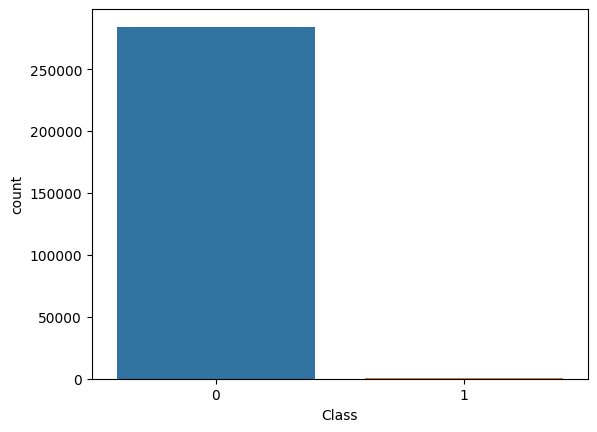

In [4]:
print(data['Class'].value_counts()[[0,1]]) 
n = data['Class'].count()

print('Proportion of Non-Fraud:', round(data['Class'].value_counts()[0]/n, 5))
print('Proportion of Fraud:', round(data['Class'].value_counts()[1]/n, 5))
sns.countplot(x = 'Class', data = data)
plt.show()

As we can see, our data is heavily unbalanced. With only 492 out of 284807 (0.172%) transactions being fraudulent.

In [5]:
#corr = round(corr,3)
corr = data.corr()
print(corr.iloc[30,0:30].sort_values().head(5))
print(corr.iloc[30,0:30].sort_values().tail(5))

V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
Name: Class, dtype: float64
V19    0.034783
V21    0.040413
V2     0.091289
V4     0.133447
V11    0.154876
Name: Class, dtype: float64


We find the 5 most positively and negatively correlated features to the response. We will look to use this subset of the data in our analysis

In [6]:
data[['Time','V2','V4','V10','V10','V11','V12',
      'V14','V16','V17','V19','V21','Amount','Class']].groupby('Class').mean()

,Time,V2,V4,V10,V10,V11,V12,V14,V16,V17,V19,V21,Amount
Class,,,,,,,,,,,,,
0,94838.202258,-0.006271,-0.007860,0.009824,0.009824,-0.006576,0.010832,0.012064,0.007164,0.011535,-0.001178,-0.001235,88.291022
1,80746.806911,3.623778,4.542029,-5.676883,-5.676883,3.800173,-6.259393,-6.971723,-4.139946,-6.665836,0.680659,0.713588,122.211321


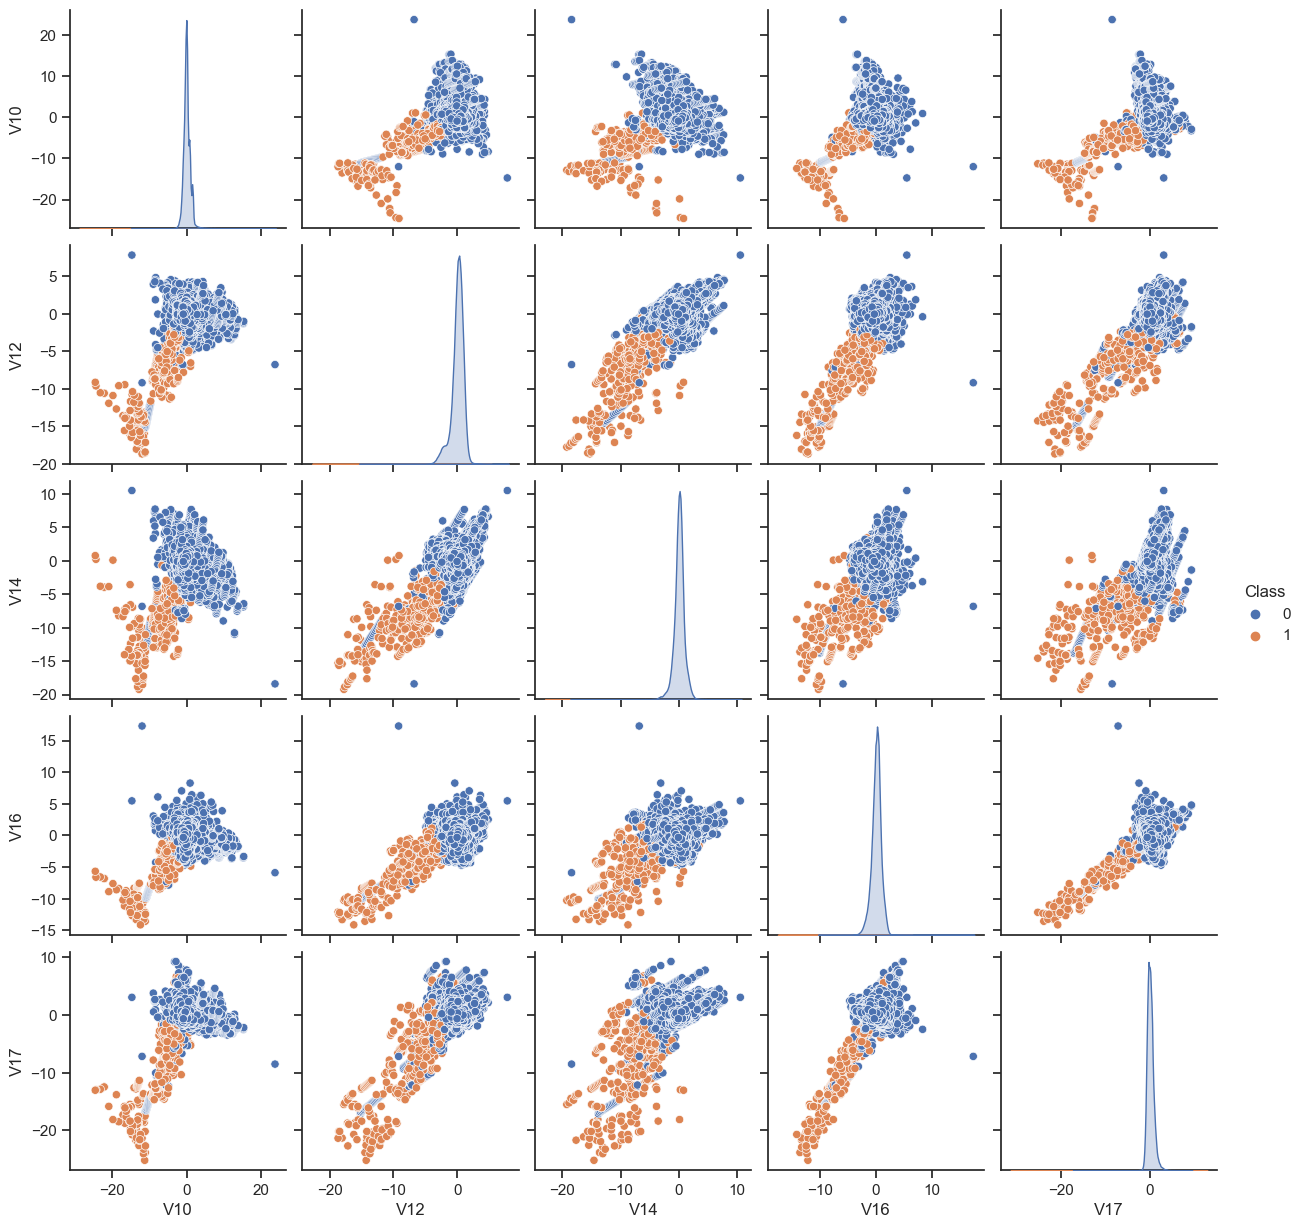

In [7]:
sns.set_theme(style="ticks")

temp = data[['V10','V12','V14','V16', 'V17','Class']]
sns.pairplot(temp, hue="Class")
plt.show()

In [ ]:
temp = data[['V2','V4','V11','V19','V21','Class']]
sns.pairplot(temp, hue="Class")
plt.show()

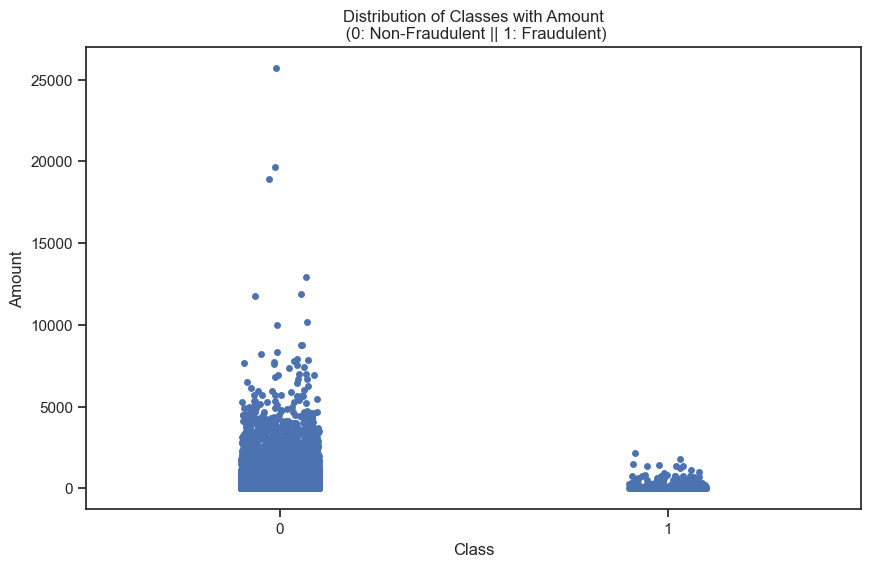

In [9]:
plt.figure(figsize=(10,6))
sns.stripplot(x= 'Class', y= 'Amount',data=data)
plt.title('Distribution of Classes with Amount\n (0: Non-Fraudulent || 1: Fraudulent)')
plt.show()

## Data Split

In [10]:
y = data['Class']
X = data.drop(['Class'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)

## Ranfom Forest - Unbalanced Data

In [11]:
rf = RandomForestClassifier()

In [12]:
parameters = {'n_estimators' : [5, 10, 25],
             'max_depth' : [2, 5, 10, None]}

cv = GridSearchCV(rf, parameters, cv=5)

In [13]:
def print_results(results):
    print("BEST PARAMS: {}\n".format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean,7), round(std*2,3), params))

In [14]:
cvfit = cv.fit(X_train, y_train)

In [15]:
print_results(cvfit)

BEST PARAMS: {'max_depth': 10, 'n_estimators': 10}

0.9991222 (+/-0.0) for {'max_depth': 2, 'n_estimators': 5}
0.9990461 (+/-0.0) for {'max_depth': 2, 'n_estimators': 10}
0.9990461 (+/-0.0) for {'max_depth': 2, 'n_estimators': 25}
0.999409 (+/-0.0) for {'max_depth': 5, 'n_estimators': 5}
0.9993797 (+/-0.0) for {'max_depth': 5, 'n_estimators': 10}
0.9993973 (+/-0.0) for {'max_depth': 5, 'n_estimators': 25}
0.9994382 (+/-0.0) for {'max_depth': 10, 'n_estimators': 5}
0.999485 (+/-0.0) for {'max_depth': 10, 'n_estimators': 10}
0.9994675 (+/-0.0) for {'max_depth': 10, 'n_estimators': 25}
0.9994324 (+/-0.0) for {'max_depth': None, 'n_estimators': 5}
0.9994558 (+/-0.0) for {'max_depth': None, 'n_estimators': 10}
0.9994675 (+/-0.0) for {'max_depth': None, 'n_estimators': 25}


In [16]:
rf1 = RandomForestClassifier(n_estimators=10, max_depth=None)
rf1.fit(X_train, y_train)

rf2 = RandomForestClassifier(n_estimators=5, max_depth=None)
rf2.fit(X_train, y_train)

rf3 = RandomForestClassifier(n_estimators=25, max_depth=10)
rf3.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=25)

In [17]:
def print_metrics_rf(mdl, X_val):
    y_pred = mdl.predict(X_val)
    y_score = mdl.predict_proba(X_val)[:, 1]
    prec, rec, thresh = precision_recall_curve(y_val, y_score)
    precision = round(precision_score(y_val, y_pred), 3)
    recall = round(recall_score(y_val, y_pred), 3)
    auroc = round(roc_auc_score(y_val, y_pred), 5)
    auprc = round(auc(rec, prec),5)
    print('MAX DEPTH: {} / # OF EST: {} --  P: {} / R: {} / AUROC: {}/ AUPRC: {}'
          .format(mdl.max_depth,mdl.n_estimators,precision,recall, auroc, auprc))

In [18]:
for mdl in [rf1, rf2, rf3]:
    print_metrics_rf(mdl, X_val)

MAX DEPTH: None / # OF EST: 10 --  P: 0.909 / R: 0.753 / AUROC: 0.87628/ AUPRC: 0.85942
MAX DEPTH: None / # OF EST: 5 --  P: 0.937 / R: 0.796 / AUROC: 0.89781/ AUPRC: 0.88084
MAX DEPTH: 10 / # OF EST: 25 --  P: 0.947 / R: 0.774 / AUROC: 0.88706/ AUPRC: 0.86128


## Oversampling

In [19]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)

In [20]:
print(ysm_train.value_counts()) 

Class
0    170583
1    170583
Name: count, dtype: int64


## Logistic Regression

In [21]:
logistic_model_os = LogisticRegression().fit(Xsm_train, ysm_train)

In [22]:
def print_metrics_lr(mdl, val, yval):
    y_pred = mdl.predict(val)
    y_prob = mdl.predict_proba(val)[:, 1]
    cm = confusion_matrix(yval, y_pred)
    Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
    Specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    prec, rec, thresh = precision_recall_curve(yval, y_prob)

    print('Accuracy: {}  \nSensitivity: {}  \nSpecificity: {}  \nPrecision: {}  \nAUROC: {} \nAUPRC: {}'
          .format(round(accuracy_score(y_pred, yval),3), round(Sensitivity,5), round(Specificity,5), 
                  round(precision_score(yval, y_pred), 3), round(roc_auc_score(yval, y_pred), 3), 
                  round(auc(rec, prec),5)))

In [23]:
print_metrics_lr(logistic_model_os, X_val, y_val)

Accuracy: 0.981  
Sensitivity: 0.91398  
Specificity: 0.98087  
Precision: 0.072  
AUROC: 0.947 
AUPRC: 0.77142


In [24]:
Xsm_train_small = Xsm_train[['Time','V2','V4','V10','V10','V11','V12','V14','V16','V17','V19','V21','Amount']]
logistic_model_os2 = LogisticRegression().fit(Xsm_train_small, ysm_train)

In [25]:
X_val_small = X_val[['Time','V2','V4','V10','V10','V11','V12','V14','V16','V17','V19','V21','Amount']]
X_test_small = X_test[['Time','V2','V4','V10','V10','V11','V12','V14','V16','V17','V19','V21','Amount']]
print_metrics_lr(logistic_model_os2, X_val_small, y_val)


Accuracy: 0.944  
Sensitivity: 0.92473  
Specificity: 0.94438  
Precision: 0.026  
AUROC: 0.935 
AUPRC: 0.74761


In [26]:
num_C = [0.001,0.01,0.1,1,10,100] #--> list of values

for cv_num in num_C:
    lr_mod = LogisticRegression(C=cv_num,random_state = 0, max_iter=1000)
    lr_mod.fit(Xsm_train, ysm_train)
    
    y_score = lr_mod.predict_proba(X_val)[:, 1]
    prec, rec, thresh = precision_recall_curve(y_val, y_score)

    print('C:', cv_num)
    print('AUPRC:', round(auc(rec, prec),5))

C: 0.001
AUPRC: 0.76299
C: 0.01
AUPRC: 0.77136
C: 0.1
AUPRC: 0.76545
C: 1
AUPRC: 0.77142
C: 10
AUPRC: 0.76554
C: 100
AUPRC: 0.76554


In [27]:
logistic_model_os3 = LogisticRegression(C=0.001).fit(Xsm_train, ysm_train)

In [28]:
print_metrics_lr(logistic_model_os3, X_val, y_val)

Accuracy: 0.982  
Sensitivity: 0.91398  
Specificity: 0.98191  
Precision: 0.076  
AUROC: 0.948 
AUPRC: 0.76299


## Cost Sensitive Logistic Regression

In [29]:
print(data['Class'].value_counts()[0]/n)
print(data['Class'].value_counts()[1]/n)

0.9982725143693799
0.001727485630620034


In [30]:
weights = {0:0.001727485630620034, 1:0.9982725143693799}
cslr = LogisticRegression(solver='lbfgs', class_weight=weights)
cslr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.001727485630620034,
                                 1: 0.9982725143693799})

In [31]:
print_metrics_lr(cslr, X_val, y_val)

Accuracy: 0.956  
Sensitivity: 0.92473  
Specificity: 0.95643  
Precision: 0.034  
AUROC: 0.941 
AUPRC: 0.73232


## Decision Tree

In [32]:
depth_score=[]
dep_rng = [x for x in range(1,10)]
for i in dep_rng:
    clf = tree.DecisionTreeClassifier(max_depth=i)
    clf.fit(X_train, y_train)
    
    y_score = clf.predict_proba(X_val)[:, 1]
    prec, rec, thresh = precision_recall_curve(y_val, y_score)
    
    depth_score.append(round(auc(rec, prec),5))
print(depth_score)

[0.70104, 0.75828, 0.79934, 0.7308, 0.74956, 0.67156, 0.69966, 0.78054, 0.76109]


In [33]:
dec_tree = tree.DecisionTreeClassifier(max_depth=3)
dec_tree.fit(X_train, y_train)
print_metrics_lr(dec_tree, X_val, y_val)

Accuracy: 0.999  
Sensitivity: 0.70968  
Specificity: 0.99977  
Precision: 0.835  
AUROC: 0.855 
AUPRC: 0.79816


In [34]:
dec_tree2 = tree.DecisionTreeClassifier(max_depth=3)
dec_tree2.fit(Xsm_train_small, ysm_train)
print_metrics_lr(dec_tree2, X_val_small, y_val)

Accuracy: 0.983  
Sensitivity: 0.88172  
Specificity: 0.98312  
Precision: 0.079  
AUROC: 0.932 
AUPRC: 0.5257


## Ranfom Forest - Oversampled Data

In [35]:
cv1 = GridSearchCV(rf, parameters, cv=5)
cvfit1 = cv1.fit(Xsm_train, ysm_train)

In [36]:
print_results(cvfit1)

BEST PARAMS: {'max_depth': None, 'n_estimators': 25}

0.945868 (+/-0.014) for {'max_depth': 2, 'n_estimators': 5}
0.9496961 (+/-0.012) for {'max_depth': 2, 'n_estimators': 10}
0.9500038 (+/-0.004) for {'max_depth': 2, 'n_estimators': 25}
0.9682002 (+/-0.003) for {'max_depth': 5, 'n_estimators': 5}
0.9690737 (+/-0.001) for {'max_depth': 5, 'n_estimators': 10}
0.9687132 (+/-0.002) for {'max_depth': 5, 'n_estimators': 25}
0.9912066 (+/-0.002) for {'max_depth': 10, 'n_estimators': 5}
0.9930327 (+/-0.002) for {'max_depth': 10, 'n_estimators': 10}
0.9934636 (+/-0.001) for {'max_depth': 10, 'n_estimators': 25}
0.9997538 (+/-0.0) for {'max_depth': None, 'n_estimators': 5}
0.9998593 (+/-0.0) for {'max_depth': None, 'n_estimators': 10}
0.9998798 (+/-0.0) for {'max_depth': None, 'n_estimators': 25}


In [37]:
rf_os1 = RandomForestClassifier(n_estimators=25, max_depth=None)
rf_os1.fit(Xsm_train, ysm_train)

rf_os2 = RandomForestClassifier(n_estimators=10, max_depth=None)
rf_os2.fit(Xsm_train, ysm_train)

rf_os3 = RandomForestClassifier(n_estimators=5, max_depth=10)
rf_os3.fit(Xsm_train, ysm_train)

RandomForestClassifier(max_depth=10, n_estimators=5)

In [38]:
for mdl in [rf_os1, rf_os2, rf_os3]:
    print_metrics_rf(mdl, X_val)

MAX DEPTH: None / # OF EST: 25 --  P: 0.827 / R: 0.871 / AUROC: 0.93533/ AUPRC: 0.87139
MAX DEPTH: None / # OF EST: 10 --  P: 0.842 / R: 0.86 / AUROC: 0.92998/ AUPRC: 0.86667
MAX DEPTH: 10 / # OF EST: 5 --  P: 0.357 / R: 0.871 / AUROC: 0.9342/ AUPRC: 0.77989


### Using Subset of Data

In [39]:
cv2 = GridSearchCV(rf, parameters, cv=5)
cvfit2 = cv2.fit(Xsm_train_small, ysm_train)

In [40]:
print_results(cvfit2)

BEST PARAMS: {'max_depth': None, 'n_estimators': 25}

0.9541631 (+/-0.007) for {'max_depth': 2, 'n_estimators': 5}
0.9497898 (+/-0.007) for {'max_depth': 2, 'n_estimators': 10}
0.9538377 (+/-0.007) for {'max_depth': 2, 'n_estimators': 25}
0.9673502 (+/-0.002) for {'max_depth': 5, 'n_estimators': 5}
0.9676873 (+/-0.002) for {'max_depth': 5, 'n_estimators': 10}
0.9693639 (+/-0.001) for {'max_depth': 5, 'n_estimators': 25}
0.9913708 (+/-0.002) for {'max_depth': 10, 'n_estimators': 5}
0.9918691 (+/-0.003) for {'max_depth': 10, 'n_estimators': 10}
0.9927865 (+/-0.001) for {'max_depth': 10, 'n_estimators': 25}
0.9995633 (+/-0.0) for {'max_depth': None, 'n_estimators': 5}
0.9997684 (+/-0.0) for {'max_depth': None, 'n_estimators': 10}
0.9998212 (+/-0.0) for {'max_depth': None, 'n_estimators': 25}


In [41]:
rf_os4 = RandomForestClassifier(n_estimators=25, max_depth=None)
rf_os4.fit(Xsm_train_small, ysm_train)

rf_os5 = RandomForestClassifier(n_estimators=10, max_depth=None)
rf_os5.fit(Xsm_train_small, ysm_train)

rf_os6 = RandomForestClassifier(n_estimators=5, max_depth=None)
rf_os6.fit(Xsm_train_small, ysm_train)

RandomForestClassifier(n_estimators=5)

In [42]:
for mdl in [rf_os4, rf_os5, rf_os6]:
    print_metrics_rf(mdl, X_val_small)

MAX DEPTH: None / # OF EST: 25 --  P: 0.766 / R: 0.882 / AUROC: 0.94064/ AUPRC: 0.87481
MAX DEPTH: None / # OF EST: 10 --  P: 0.781 / R: 0.882 / AUROC: 0.94066/ AUPRC: 0.85496
MAX DEPTH: None / # OF EST: 5 --  P: 0.672 / R: 0.882 / AUROC: 0.94051/ AUPRC: 0.83868


## Support Vector Machine

### Full Data

In [43]:
# svm = SVC(kernel='poly',degree=5, random_state=42)
# svm.fit(X_train, y_train)

In [44]:
svm1 = svm.SVC(kernel='linear', probability=True) # Linear Kernel

In [45]:
svm1.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

In [46]:
print_metrics_lr(svm1, X_val, y_val)

Accuracy: 0.999  
Sensitivity: 0.4086  
Specificity: 0.99972  
Precision: 0.704  
AUROC: 0.704 
AUPRC: 0.33461


In [47]:
svm2 = svm.SVC(kernel='poly',degree=5, random_state=42, probability=True)

In [48]:
svm2.fit(X_train, y_train)

SVC(degree=5, kernel='poly', probability=True, random_state=42)

In [49]:
print_metrics_lr(svm2, X_val, y_val)
warnings.filterwarnings("ignore", category=FutureWarning)

Accuracy: 0.998  
Sensitivity: 0.0  
Specificity: 1.0  
Precision: 0.0  
AUROC: 0.5 
AUPRC: 0.00255


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN

In [50]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
print_metrics_lr(knn1, X_val, y_val)

Accuracy: 0.998  
Sensitivity: 0.17204  
Specificity: 0.9996  
Precision: 0.41  
AUROC: 0.586 
AUPRC: 0.29183


In [51]:
neighbours = np.arange(1,10)
val_auprc = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k, algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_train, y_train)
    
    y_score = knn.predict_proba(X_val)[:, 1]
    
    prec, rec, thresh = precision_recall_curve(y_val, y_score)
    
    val_auprc[i] = round(auc(rec, prec),5)

In [52]:
val_auprc

array([0.29183, 0.25172, 0.2122 , 0.17146, 0.14834, 0.12884, 0.13752,
       0.13646, 0.12986])

## Naive Bayes

In [53]:
gnb = GaussianNB()
gnbclsf = gnb.fit(X_train, y_train)

In [54]:
print_metrics_lr(gnbclsf, X_val, y_val)

Accuracy: 0.993  
Sensitivity: 0.69892  
Specificity: 0.99379  
Precision: 0.156  
AUROC: 0.846 
AUPRC: 0.38632


## XGBoost

In [55]:
xgbst = XGBClassifier()

param_xgb = {'n_estimators': [130,140,150],
              'max_depth': [3, 5, 7],
               'min_child_weight':[1,2,3]
             } 

clf_xgb_cv = GridSearchCV(xgbst, param_xgb, cv=3,scoring='roc_auc', n_jobs=-1)
clf_xgb_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",clf_xgb_cv.best_params_)
print("accuracy :",clf_xgb_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150}
accuracy : 0.9774531134723011


In [56]:
xgbst = XGBClassifier(n_estimators=150,max_depth=5,min_child_weight=3)

xgb_clf = xgbst.fit(X_train, y_train)

In [57]:
print_metrics_lr(xgbst, X_val, y_val)

Accuracy: 1.0  
Sensitivity: 0.8172  
Specificity: 0.99989  
Precision: 0.927  
AUROC: 0.909 
AUPRC: 0.88764


In [58]:
xgbst2 = XGBClassifier(n_estimators=150,max_depth=5,min_child_weight=3)
xgb_clf2 = xgbst2.fit(Xsm_train, ysm_train)

In [59]:
print_metrics_lr(xgbst2, X_val, y_val)

Accuracy: 0.999  
Sensitivity: 0.88172  
Specificity: 0.99956  
Precision: 0.766  
AUROC: 0.941 
AUPRC: 0.88848


## Neural Networks

We first scale the data in order to be used in the neural network

In [60]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

negcount, poscount = np.bincount(data['Class'])
initial_bias = np.log([poscount/negcount])

In [61]:
def make_model(metrics=keras.metrics.AUC(name='prc', curve='PR'), output_bias=None):
    output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(X_train_scale.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

    model.compile(
      optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [62]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [68]:
nn_model = make_model(output_bias=initial_bias)
baseline_history = nn_model.fit(
    X_train_scale,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(X_val_scale, y_val),
    verbose=0)

Restoring model weights from the end of the best epoch: 63.
Epoch 73: early stopping


In [69]:
y_score = nn_model.predict(X_val_scale)
prec, rec, thresh = precision_recall_curve(y_val, y_score)
round(auc(rec, prec),5)

1781/1781 [==============================] - 0s 215us/step


0.82025

## Comparing Best Models Using Test Data

In [70]:
def print_auprc(mdl, val, yval):
    y_pred = mdl.predict(val)
    y_prob = mdl.predict_proba(val)[:, 1]
    prec, rec, thresh = precision_recall_curve(yval, y_prob)

    print('AUPRC: {}'.format(round(auc(rec, prec),5)))
    
def print_auprc_nn(mdl, val, yval):
    y_score = mdl.predict(val)
    prec, rec, thresh = precision_recall_curve(yval, y_score)
    print('AUPRC: {}'.format(round(auc(rec, prec),5)))

In [72]:
print("rf3")
print_auprc(rf3, X_test, y_test)
print("logistic_model_os")
print_auprc(logistic_model_os, X_test, y_test)
print("cslr")
print_auprc(cslr, X_test, y_test)
print("dec_tree")
print_auprc(dec_tree, X_test, y_test)
print("rf_os1")
print_auprc(rf_os1, X_test, y_test)
print("rf_os4")
print_auprc(rf_os4, X_test_small, y_test)
print("svm1")
print_auprc(svm1, X_test, y_test)
print("knn1")
print_auprc(knn1, X_test, y_test)
print("gnbclsf")
print_auprc(gnbclsf, X_test, y_test)
print("xgbst2")
print_auprc(xgbst2, X_test, y_test)
print("nn_model")
print_auprc_nn(nn_model, X_test_scale, y_test)

rf3
AUPRC: 0.8151
logistic_model_os
AUPRC: 0.75631
cslr
AUPRC: 0.70932
dec_tree
AUPRC: 0.79965
rf_os1
AUPRC: 0.83925
rf_os4
AUPRC: 0.85899
svm1
AUPRC: 0.26583
knn1
AUPRC: 0.30539
gnbclsf
AUPRC: 0.3325
xgbst2
AUPRC: 0.85715
nn_model
1781/1781 [==============================] - 0s 234us/step
AUPRC: 0.80711


# Conclusion

Based on the evaluations on the test data. The best model in predicting credit card fraud according to AUPRC is the random forest model that was fit to the oversmapled SMOTE data, using only the predictors that were most highly correlated with the response (Time, V2, V4, V10, V10, V11, V12, V14, V16, V17, V19 ,V21, Amount), with no max depth specified and 25 estimators.
A close second would be the XGBoost model that was fit to the oversampled SMOTE data. 